# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [48]:
import pandas as pd
import numpy as np
import math
import json
from time import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm import tqdm

import random
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

%matplotlib inline

In [59]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Overview and Problem statement:
## What question are we asking?
## What types of offers are most successful and will drive more business and what features will drive successful offers?

So a two fold question:
- Which offers are the most successful
- Which features lead to successful offers? 

Why are these questions important? The first will allow us to target the types of offers that are most likely to be successful and generate revenue based on that. The second question will allow us to target those offers to those most likely to participate and again, generate revenue.

## Data Investigation/Analysis
### portfolio data

In [60]:
# what does the portfolio data look like
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [61]:
# what are the data types, counts, etc.
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


#### Portfolio Cleansing
- Will need to change channels column to one-hot encoded column from list
- give the id a meaningful name and/or one-hot encode the offer_type column to make things easier to read?

###  profile data

In [62]:
# what does the profile data look like
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [63]:
# what are the data types, counts, etc.
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


#### Profile Cleansing

- there are nulls in income and gender
- became_member_on is an integer (but an integer that shows yyyymmdd rather than timestamp type integer), should be a date, need to fix that

#### Profile Visualizations

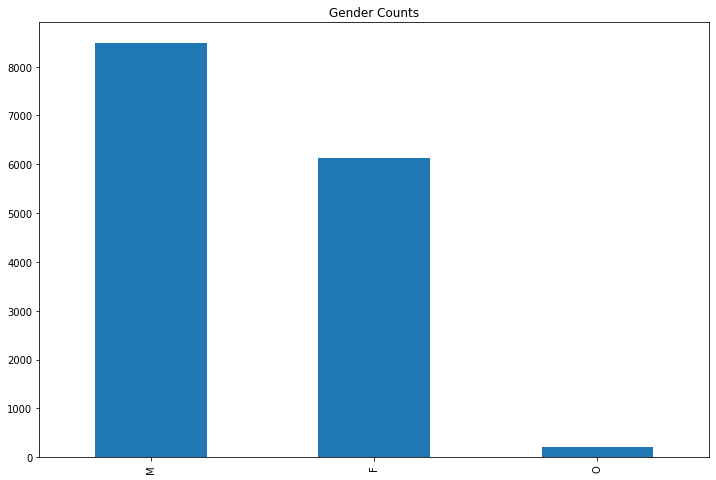

In [64]:
# Let's look at the distribution of gender

profile.gender.value_counts().plot(kind='bar', figsize=(12,8), title='Gender Counts')

Text(0.5, 1.0, 'Income By Gender')

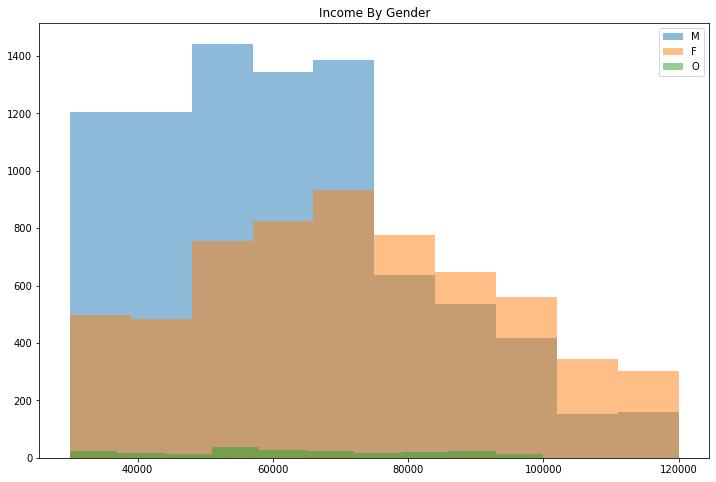

In [65]:
# How about income by gender

f, ax = plt.subplots(1, figsize=(12,8))

ax.hist(profile[profile.gender == 'M']['income'], alpha=0.5, label='M')
ax.hist(profile[profile.gender == 'F']['income'], alpha=0.5, label='F')
ax.hist(profile[profile.gender == 'O']['income'], alpha=0.5, label='O')
ax.legend()
plt.title('Income By Gender')

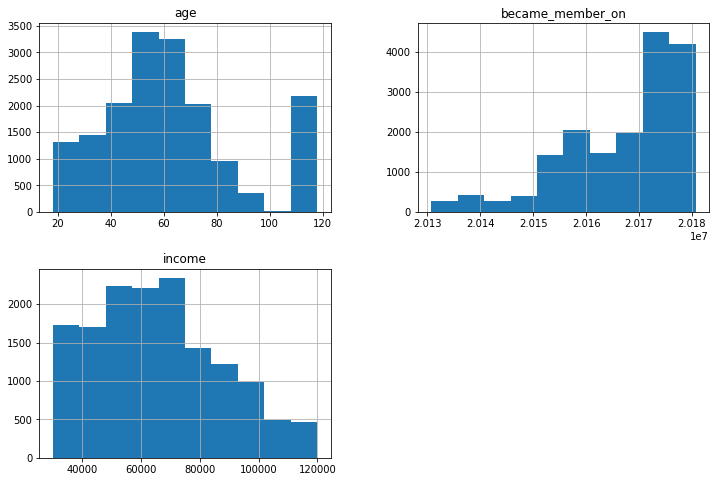

In [66]:
# Let's look at some of the other values (note 118 for age means no age submitted, so it's a not-null-null type situation)

profile[['age', 'income', 'became_member_on']].hist(figsize=(12,8));

There are good number of 118 age values, let's look deeper, how many:

In [67]:
profile[profile.age == 118]['age'].value_counts()

118    2175
Name: age, dtype: int64

In [68]:
# How many null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Interestingly enough there are the same number of null values in gender and income, which is equal to the number of "null" ages (set to 118), might be a pattern here to explore.
### transcript data

In [69]:
# what does the transcript data look like
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [70]:
# what are the data types, counts, etc.
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [71]:
# how many of each type of event are there?
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

#### NOTE:
So to be valid, an offer must be recieved, viewed then completed, if completed without the view step we should likely ignore or treat it differently

#### Transcript cleansing
- That value column should likely be broken out so that the offer id value is joinable to the portfolio id column, but we also have the transaction amount to worry about
- time is also in hours but duration is days, we should change time to days (divide by 24 and round up)

## Data Cleansing

In [72]:
# get clean dataframes to work with

portfolio_clean = portfolio
profile_clean = profile
transcript_clean = transcript

### Cleaning portfolio data
#### One-hot encode channels column 

In [73]:
portfolio_clean = portfolio_clean.drop('channels', 1).join(portfolio_clean.channels.str.join('|').str.get_dummies())

In [74]:
# confirm column creation
portfolio_clean.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


#### Create offer_name column by concatenating the offer_type, difficulty, duration and reward
This will be good shorthand for id, which is not really meaningful

In [75]:
portfolio_clean['offer_name'] = portfolio_clean.offer_type.astype(str) + '_' + portfolio_clean.difficulty.astype(str) + \
    '_' + portfolio_clean.duration.astype(str) + '_' + portfolio_clean.reward.astype(str)

In [76]:
# confirm column creation
portfolio_clean.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web,offer_name
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,bogo_10_7_10
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,bogo_10_5_10
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,informational_0_4_0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,bogo_5_7_5
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,discount_20_10_5


#### One-hot encode offer_type column 

In [77]:
portfolio_clean = pd.get_dummies(portfolio_clean, columns=['offer_type'])
portfolio_clean.rename(columns = {'offer_type_bogo':'bogo', 'offer_type_informational':'informational', 
                                   'offer_type_discount':'discount'}, inplace=True)
# confirm data manipulation
portfolio_clean.head()

,difficulty,duration,id,reward,email,mobile,social,web,offer_name,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,bogo_10_7_10,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,bogo_10_5_10,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,informational_0_4_0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,bogo_5_7_5,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,discount_20_10_5,0,1,0


#### Rename id to offerid

In [78]:
portfolio_clean.rename(columns= {'id':'offerid'}, inplace=True)
# confirm change in name
portfolio_clean.head()

,difficulty,duration,offerid,reward,email,mobile,social,web,offer_name,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,bogo_10_7_10,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,bogo_10_5_10,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,informational_0_4_0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,bogo_5_7_5,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,discount_20_10_5,0,1,0


### Cleaning profile data
#### Transform became_member_on from integer to datetype
Convert to str then use to_datetime to format the date in yyyy-mm-dd format
Do we really need this or only the year, let's try just the first four characters and see what we get

In [79]:
# clean up profile became_member_on date
profile_clean.became_member_on = profile_clean.became_member_on.apply(lambda x: str(x))

profile_clean.became_member_on = profile_clean.became_member_on.str[:4]
profile_clean.became_member_on = profile_clean.became_member_on.astype(int)
# confirm data change
profile_clean.head()

,age,became_member_on,gender,id,income
0,118,2017,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [80]:
# how many of each year do we have?
profile_clean.became_member_on.value_counts()

2017    6469
2018    4198
2016    3526
2015    1830
2014     691
2013     286
Name: became_member_on, dtype: int64

In [81]:
# did the column data change take?
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int32
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 597.7+ KB


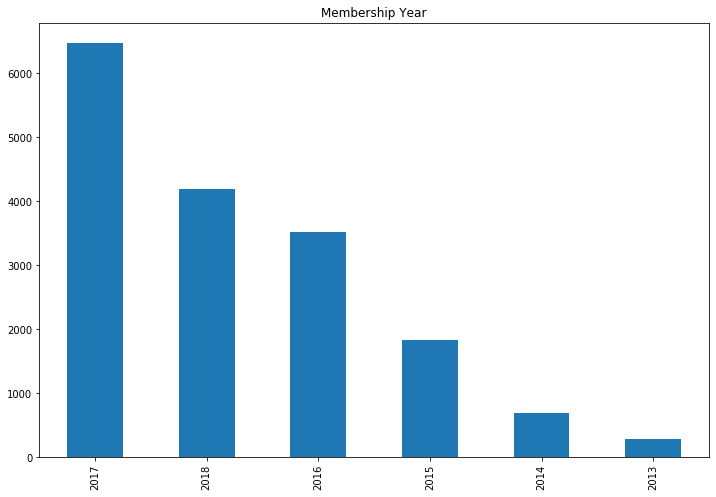

In [82]:
# Let's see what it looks like:
profile_clean.became_member_on.value_counts().plot(kind='bar', figsize=(12,8), title='Membership Year')

#### Rename id to person_id

In [83]:
profile_clean.rename(columns= {'id':'person_id'}, inplace=True)
# confirm column name change
profile_clean.head()

,age,became_member_on,gender,person_id,income
0,118,2017,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017,None,a03223e636434f42ac4c3df47e8bac43,NaN


### cleaning transcript data
#### The value column should likely be broken out so that the offer id value is joinable to the portfolio id column

In [84]:
def get_offer_id(x):
    '''
    Gets an 'offer id/offer_id' from the transaction dataframe based on the value column

    Args:
        (str) x - offer id or offer_id
    Returns:
        (str) x  - an offer id
    '''
    try:
        return x['offer id']
    except:
        return x['offer_id']
    
def get_offer_or_amount(df):
    '''
    Gets an 'offer id/offer_id' from the transaction dataframe based on the value column

    Args:
        (dataframe) df - a dataframe with the value column (with dictionary value for offer id/offer_id)
    Returns:
        (dataframe) df_clean  - a dataframe with offer_id column containing offer id/offer_id from value column
    '''
    df_clean = df.copy()
    df_clean['offer_id'] = df[df.event.isin(['offer received', 'offer viewed', 'offer completed'])].value.apply(get_offer_id)
    df_clean['amount'] = df[df.event.isin(['transaction'])].value.apply(lambda x: x['amount'])
    return df_clean

In [85]:
# get the offer ids from the value column
transcript_clean = get_offer_or_amount(transcript_clean)
# confirm the new column exists
transcript_clean.head()

,event,person,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [86]:
# confirm the tail of the dataframe
transcript_clean.tail()

,event,person,time,value,offer_id,amount
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999},NaN,1.59
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53},NaN,9.53
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61},NaN,3.61
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002},NaN,3.53
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05},NaN,4.05


##### One-hot encode the events and then compare the values

In [87]:
# copy the event column (not sure I want to get rid of it, yet)
transcript_clean['evt'] = transcript_clean['event']

# one-hot encode the evt column
transcript_clean = pd.get_dummies(transcript_clean, columns=['evt'])
# rename the columns to be more meaningful
transcript_clean.rename(columns = {'evt_offer completed':'completed', 'evt_offer received':'received', 
                                   'evt_offer viewed':'viewed', 'evt_transaction':'transaction'}, inplace=True)
# confirm column changes
transcript_clean.head()

,event,person,time,value,offer_id,amount,completed,received,viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0


####  Convert time to days (divide by 24 and round up) 

In [88]:
transcript_clean['time'] = transcript_clean.time.div(24).apply(np.ceil)

In [32]:
# save all clean dataframes to csv just in case needed

transcript_clean.to_csv('data/transcript_clean.csv', index=False)
portfolio_clean.to_csv('data/portfolio_clean.csv', index=False)
profile_clean.to_csv('data/profile_clean.csv', index=False)

now we can drop the value column (and maybe the event column, we'll get to that) then we need to flatten 

### Merge the dataframes to create a master dataframe

In [89]:
# merge profile to transcript

transcript_n_profile_df = pd.merge(transcript_clean, profile_clean, left_on=['person'], right_on=['person_id'], how='left')
transcript_n_profile_df.drop(['person_id'], axis=1, inplace=True)

# merge the transcript_n_profile_df to portfolio

merged_df = pd.merge(transcript_n_profile_df, portfolio_clean, left_on=['offer_id'], right_on=['offerid'], how='left')
merged_df.drop(['offerid'], axis=1, inplace=True)

merged_df.head()
                                                                                    

,event,person,time,value,offer_id,amount,completed,received,viewed,transaction,...,duration,reward,email,mobile,social,web,offer_name,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,...,7.0,5.0,1.0,1.0,0.0,1.0,bogo_5_7_5,1.0,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,...,10.0,5.0,1.0,0.0,0.0,1.0,discount_20_10_5,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,...,7.0,2.0,1.0,1.0,0.0,1.0,discount_10_7_2,0.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,...,10.0,2.0,1.0,1.0,1.0,1.0,discount_10_10_2,0.0,1.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,...,5.0,10.0,1.0,1.0,1.0,1.0,bogo_10_5_10,1.0,0.0,0.0


Let's look at our merged data now, how does the event column break down?

### Data Analysis Part II (using the merged data set)
#### More visualizations on the combined dataset
Let's look at some of the demographic data, age, membership year, income

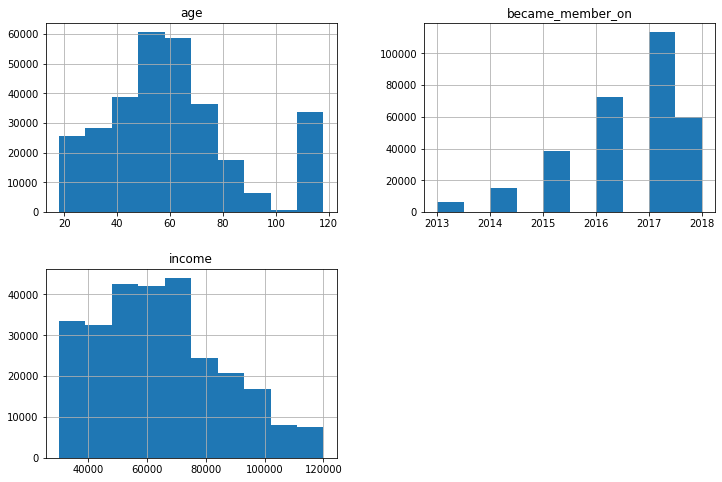

In [90]:
# Let's view our demographic type data

merged_df[['age', 'income', 'became_member_on']].hist(figsize=(12,8));

So our general peak age range is late 40's to early 70's with membership beginning in 2017 and income between 50k and 70k
#### Visualize Events
Now, what are the events we have our merged data set

C:\Users\drche\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


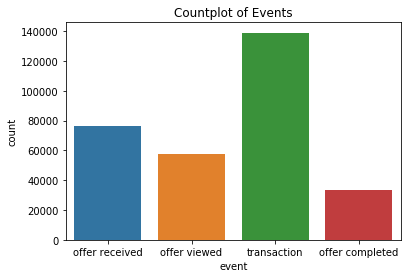

In [92]:
sns.countplot('event', data=merged_df)
plt.title('Countplot of Events');

#### Visualize Offers
Let's see how many of each type of offer is sent out

C:\Users\drche\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


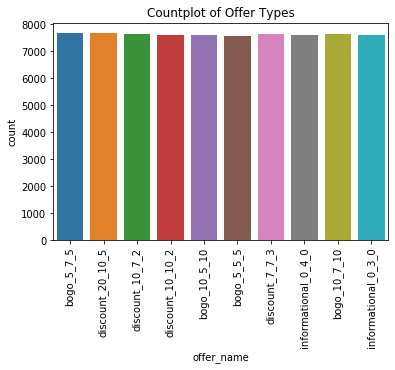

In [93]:
received = merged_df[merged_df.event =='offer received']

sns.countplot(received['offer_name'])
plt.xticks(rotation=90)
plt.title('Countplot of Offer Types');

Interesting, looks like the numbers are fairly close, some very minor variation.
#### Review Transaction Amounts
What about the transaction amounts, now that we've broken out the value column (and merged it)? What do those look like?

In [94]:
merged_df.groupby('person')['amount'].mean().describe()

count    16578.000000
mean        13.680266
std         16.056763
min          0.050000
25%          3.181392
50%         11.996607
75%         20.469643
max        451.470000
Name: amount, dtype: float64

#### Visualize Events grouped by Offer Type
Now let's look at the offer_name versus the events (received, viewed and completed). Per the documentation we'll need to understand this better since offers received and completed that aren't viewed won't really be valid since we assume the person did not act on an offer they didn't know about

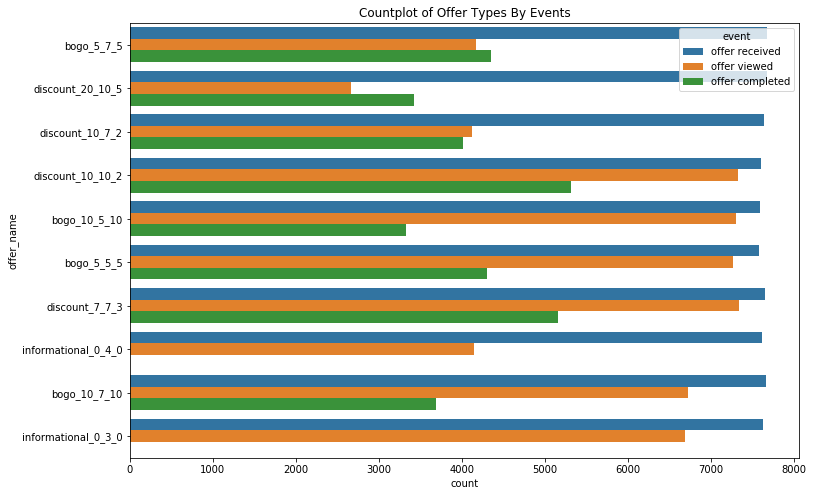

In [95]:
plt.figure(figsize=(12,8))
# we only need offers received, viewed and completed, ignore or exclude transactions
sns.countplot(y='offer_name', hue='event', data=merged_df[~merged_df.event.isin(['transaction'])])
plt.title('Countplot of Offer Types By Events');

#### Analysis commentary:
So, as we suspected (per the documentation) several offers (bogo_5_7_5 and discount_20_10_5, for example) have more completed than viewed, we'll have to fix that.
#### Additional encoding thought
What if we one-hot encode the events and then compare the values.

Let's look at a single person's events

In [96]:
merged_df[merged_df['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value,offer_id,amount,completed,received,viewed,transaction,...,duration,reward,email,mobile,social,web,offer_name,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,...,7.0,5.0,1.0,1.0,0.0,1.0,bogo_5_7_5,1.0,0.0,0.0
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,1.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0,...,7.0,5.0,1.0,1.0,0.0,1.0,bogo_5_7_5,1.0,0.0,0.0
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.0,{'amount': 19.89},NaN,19.89,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,6.0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,0,0,...,7.0,5.0,1.0,1.0,0.0,1.0,bogo_5_7_5,1.0,0.0,0.0
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.0,{'amount': 17.78},NaN,17.78,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,0,1,0,0,...,3.0,0.0,1.0,1.0,1.0,0.0,informational_0_3_0,0.0,0.0,1.0
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,0,0,1,0,...,3.0,0.0,1.0,1.0,1.0,0.0,informational_0_3_0,0.0,0.0,1.0
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,10.0,{'amount': 19.67},NaN,19.67,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,10.0,{'amount': 29.72},NaN,29.72,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,16.0,{'amount': 23.93},NaN,23.93,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Additional Commentary:
So for analysis I want only one row per person per offer, need to flatten the events columns based on that, 
then create the successful offer above
####  Users with transactions but no offers
There appear to be six users that don't have any offers associated only transactions we'll need to clean those up in the process, 

In [97]:
# clean up the users with transactions but no other events
merged_df = merged_df[merged_df.person.isin(merged_df[merged_df.transaction == 0].person.unique())]

### Determining valid offers
As noted in the NOTE in the transcript data section, for an offer to be valid it must have been both recieved and viewed, but also happened within a certain period of time. Let's create function to create valid column.

In [41]:
def valid_offers(df):
    '''
    Function to create a list of valid offers (offers that have been received and viewed and then potentially completed)

    Args:
        (dataframe) df - a dataframe offers
    Returns:
        (list) valid_offer  - a list containing the index of a valid offer
    '''
    
    valid_offer = []

    for person in tqdm(df[df.transaction == 0].person.unique()):
        people_df = df[df.person == person]
        complete_df = people_df[people_df.event == 'offer completed']

        for offer in complete_df.offer_id.unique():
            comp = complete_df[complete_df.offer_id == offer]
            start_time = comp.time.values - comp.duration.values
            comp_time = comp.time.values
            people = people_df[(people_df.time >= start_time[0]) & (people_df.time <= comp.time.values[0])]
            viewed = people[(people.event == 'offer viewed') & (people.offer_id == offer)]
            if viewed.shape[0] > 0:
                valid_offer.extend(comp.index)
    return valid_offer

In [42]:
successful_offers = valid_offers(merged_df)

merged_df.loc[merged_df.index.isin(successful_offers), 'valid'] = 0
merged_df.loc[~merged_df.index.isin(successful_offers), 'valid'] = 1

100%|████████████████████████████████████████████████████████████████████████████| 16994/16994 [05:34<00:00, 50.81it/s]


In [98]:
# let's view our new valid column
merged_df.head()

,event,person,time,value,offer_id,amount,completed,received,viewed,transaction,...,duration,reward,email,mobile,social,web,offer_name,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,...,7.0,5.0,1.0,1.0,0.0,1.0,bogo_5_7_5,1.0,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,...,10.0,5.0,1.0,0.0,0.0,1.0,discount_20_10_5,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,...,7.0,2.0,1.0,1.0,0.0,1.0,discount_10_7_2,0.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,...,10.0,2.0,1.0,1.0,1.0,1.0,discount_10_10_2,0.0,1.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,...,5.0,10.0,1.0,1.0,1.0,1.0,bogo_10_5_10,1.0,0.0,0.0


In [100]:
# save our data off
merged_df.to_csv('data/merged_data.csv', index=False)

### Feature Creation and Analysis

Now our data is mostly cleansed and we have a good idea of the types of events and transactions let's start working on refining our features

In [101]:
# load dataframe (if necessary)
data_df = pd.read_csv('data/merged_data.csv')

In [102]:
# view data
data_df.head()

,event,person,time,value,offer_id,amount,completed,received,viewed,transaction,...,duration,reward,email,mobile,social,web,offer_name,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,...,7.0,5.0,1.0,1.0,0.0,1.0,bogo_5_7_5,1.0,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,...,10.0,5.0,1.0,0.0,0.0,1.0,discount_20_10_5,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,...,7.0,2.0,1.0,1.0,0.0,1.0,discount_10_7_2,0.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,...,10.0,2.0,1.0,1.0,1.0,1.0,discount_10_10_2,0.0,1.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,...,5.0,10.0,1.0,1.0,1.0,1.0,bogo_10_5_10,1.0,0.0,0.0


#### Missing demographic data
Now let's investigate those records missing demographic data (gender, income, and age).

In [103]:
data_df.shape[0]

306514

In [104]:
data_df.isnull().sum()

event                    0
person                   0
time                     0
value                    0
offer_id            138933
amount              167581
completed                0
received                 0
viewed                   0
transaction              0
age                      0
became_member_on         0
gender               33771
income               33771
difficulty          138933
duration            138933
reward              138933
email               138933
mobile              138933
social              138933
web                 138933
offer_name          138933
bogo                138933
discount            138933
informational       138933
dtype: int64

#### Analysis Commentary:
So one thing we do know, is that transactions will not have offer_id's (or offer_id related fields like difficulty or discount), so that explains those. Events that aren't transactions won't have amounts. We still have genders and income to consider.

In the data mapping above we are also told that age of 118 is equal to no age entered, how many of those do we have?

In [105]:
# How many age 118 exist
data_df[data_df.age == 118]['age'].value_counts()

118    33771
Name: age, dtype: int64

So it looks like 33771 out of 306534 records are missing demographic data, I would think for our second question we'll want to drop that, since we still have plenty of data to work with. For the first question, we'll use all the data, since we're concerned about the offers specifically.

## First Question

For our first question, we'll use all the data, what type of offers are the most successful. 

We won't really need any machine learning on this one.We'll need to flatten the data, what we want is one record for each person and offer (transactions removed) with the remaining data combined.

In [106]:
# how many non-transactional data rows are there?
data_df[data_df.transaction == 0]['transaction'].value_counts()

0    167581
Name: transaction, dtype: int64

In [107]:
# create a person offer dataframe without transaction data
person_offer_df = data_df[data_df.transaction == 0]

person_offer_df.head(5)

,event,person,time,value,offer_id,amount,completed,received,viewed,transaction,...,duration,reward,email,mobile,social,web,offer_name,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,...,7.0,5.0,1.0,1.0,0.0,1.0,bogo_5_7_5,1.0,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,...,10.0,5.0,1.0,0.0,0.0,1.0,discount_20_10_5,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,...,7.0,2.0,1.0,1.0,0.0,1.0,discount_10_7_2,0.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,...,10.0,2.0,1.0,1.0,1.0,1.0,discount_10_10_2,0.0,1.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,...,5.0,10.0,1.0,1.0,1.0,1.0,bogo_10_5_10,1.0,0.0,0.0


In [108]:
# let's view a sample person to get an idea of what sorts are records we're working with

data_df[data_df.person == '78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value,offer_id,amount,completed,received,viewed,transaction,...,duration,reward,email,mobile,social,web,offer_name,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,...,7.0,5.0,1.0,1.0,0.0,1.0,bogo_5_7_5,1.0,0.0,0.0
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,1.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0,...,7.0,5.0,1.0,1.0,0.0,1.0,bogo_5_7_5,1.0,0.0,0.0
47580,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.0,{'amount': 19.89},NaN,19.89,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47581,offer completed,78afa995795e4d85b5d9ceeca43f5fef,6.0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,0,0,...,7.0,5.0,1.0,1.0,0.0,1.0,bogo_5_7_5,1.0,0.0,0.0
49500,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.0,{'amount': 17.78},NaN,17.78,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53174,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,0,1,0,0,...,3.0,0.0,1.0,1.0,1.0,0.0,informational_0_3_0,0.0,0.0,1.0
85288,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,0,0,1,0,...,3.0,0.0,1.0,1.0,1.0,0.0,informational_0_3_0,0.0,0.0,1.0
87131,transaction,78afa995795e4d85b5d9ceeca43f5fef,10.0,{'amount': 19.67},NaN,19.67,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92100,transaction,78afa995795e4d85b5d9ceeca43f5fef,10.0,{'amount': 29.72},NaN,29.72,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141557,transaction,78afa995795e4d85b5d9ceeca43f5fef,16.0,{'amount': 23.93},NaN,23.93,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
def create_person_offer_feature(df_in):
    '''
    Function to create a dataframe that contains a flattened version of the merged_df, combining all the numeric fields

    Args:
        (dataframe) df_in - a dataframe with multiple records of persons and offers
    Returns:
        (dataframe) df_out  - a dataframe that has only one person per offer

    '''

    df_out = pd.DataFrame(columns=['person', 'offer_id', 'time', 'completed', 'received', 'viewed', 'difficulty', 'duration', 
                                   'offer_name', 'reward', 'email', 'mobile', 'social', 'web', 'valid', 'bogo', 
                                   'informational', 'discount'])
    df_offer = df_out

    for person in tqdm(df_in.person.unique()):

        people_df = df_in[df_in.person == person]

        for offer in people_df.offer_id.unique():

            offer_df = people_df[people_df.offer_id == offer]
            
            pers = offer_df.person.unique().item(0)

            time = offer_df.time.values.max()
            completed = offer_df.completed.values.max()
            received = offer_df.received.values.max()
            viewed = offer_df.viewed.values.max()
            valid = offer_df.valid.values.max()

            difficulty = offer_df.difficulty.unique().item(0)
            duration = offer_df.duration.unique().item(0)
            offer_name = offer_df.offer_name.unique().item(0)
            reward = offer_df.reward.unique().item(0)
            email = offer_df.email.unique().item(0)
            mobile = offer_df.mobile.unique().item(0)
            social = offer_df.social.unique().item(0)
            web = offer_df.web.unique().item(0)
            bogo = offer_df.bogo.unique().item(0)
            informational = offer_df.informational.unique().item(0)
            discount= offer_df.discount.unique().item(0)

            df_offer = pd.DataFrame([[pers, offer, time, completed, received, viewed, difficulty, duration, offer_name, 
                                      reward, email, mobile, social, web, valid, bogo, informational, discount]], 
                                    columns=['person', 'offer_id', 'time', 'completed','received', 'viewed', 'difficulty', 
                                      'duration', 'offer_name', 'reward', 'email', 'mobile',
                                      'social', 'web', 'valid', 'bogo', 'informational', 'discount'])
            
            df_out = df_out.append(df_offer)

    return df_out

In [55]:
# run the above function to create person offer features dataframe
pers_offer_feature_df = create_person_offer_feature(person_offer_df)

100%|████████████████████████████████████████████████████████████████████████████| 16994/16994 [15:21<00:00, 18.45it/s]


In [56]:
# review person offer dataframe
pers_offer_feature_df.head()

,person,offer_id,time,completed,received,viewed,difficulty,duration,offer_name,reward,email,mobile,social,web,valid,bogo,informational,discount
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.0,1,1,1,5.0,7.0,bogo_5_7_5,5.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
0,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,9.0,0,1,1,0.0,3.0,informational_0_3_0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
0,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,22.0,1,1,1,10.0,7.0,bogo_10_7_10,10.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
0,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,25.0,1,1,1,5.0,5.0,bogo_5_5_5,5.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,26.0,0,1,1,20.0,10.0,discount_20_10_5,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [57]:
# get some information about person offer feature dataframe
pers_offer_feature_df.shape[0]

63288

In [58]:
# save off dataframe to csv for use later
pers_offer_feature_df.to_csv('data/profile_offer_feature.csv', index=False)

### So which offers are successful (valid and complete)?

In [109]:
# create new working dataframes from previous cleansed data

working_df = pd.read_csv('data/profile_offer_feature.csv')
profile_clean = pd.read_csv('data/profile_clean.csv')
merged_df = pd.read_csv('data/merged_data.csv')

In [110]:
# let's make sure we're only working with valid offers
working_df = working_df[working_df.valid == 1]

In [111]:
# how big is our dataframe
working_df.shape[0]

63288

In [112]:
# how successful are our offers based on simple completion values
working_df[working_df.completed == 1]['offer_name'].value_counts() / working_df.offer_name.value_counts()

bogo_10_5_10           0.455766
bogo_10_7_10           0.498431
bogo_5_5_5             0.597413
bogo_5_7_5             0.595437
discount_10_10_2       0.715414
discount_10_7_2        0.553699
discount_20_10_5       0.467211
discount_7_7_3         0.698972
informational_0_3_0         NaN
informational_0_4_0         NaN
Name: offer_name, dtype: float64

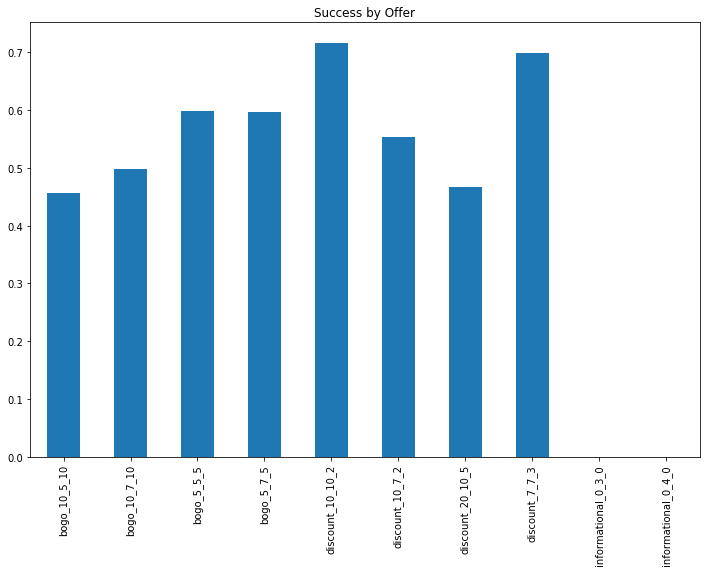

In [113]:
# visualize the offers
(working_df[working_df.completed == 1]['offer_name'].value_counts() / working_df.offer_name.value_counts()).plot(kind='bar', figsize=(12,8), title='Success by Offer')

#### Analysis Discussion:
So in the most simple manner, discounts seem to work the best, with discount_10_10_2 having the highest success at about 72% while discount_7_7_3 is the next most at 70%. The bogo_5_5_5 and bogo_5_7_5 are both pretty good at 60% each.

Recall as well our format for naming, offer type, difficulty, duration then reward, so lower difficulty discounts seems more successfuly than higher difficulty (20's). Surprisingly lower rewards in the discount range were more successful.

The same held true for the bogo offers, lowwer duration (5 vs 10) and lower rewards were more successful (5 vs 10 there as well).

### So now we know a couple of successful offers, can we learn anything from them?

And if so, can we then create a machine learning algorith that will give us decent predictions that we can use to determine what features are important so we can target our offers to that demographic?

#### Transform categorical features
First lets encode the gender to make it numerical for later
M = 0
F = 1 
O = 2

In [114]:
# create a feature dataframe to work from
feature_df = working_df

In [115]:
# merge the original clean profile dataframe back into the feature frame
feature_df = pd.merge(feature_df, profile_clean, left_on=['person'], right_on=['person_id'], how='left')

feature_df.head()

,person,offer_id,time,completed,received,viewed,difficulty,duration,offer_name,reward,...,web,valid,bogo,informational,discount,age,became_member_on,gender,person_id,income
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.0,1,1,1,5.0,7.0,bogo_5_7_5,5.0,...,1.0,1.0,1.0,0.0,0.0,75,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,9.0,0,1,1,0.0,3.0,informational_0_3_0,0.0,...,0.0,1.0,0.0,1.0,0.0,75,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,22.0,1,1,1,10.0,7.0,bogo_10_7_10,10.0,...,0.0,1.0,1.0,0.0,0.0,75,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,25.0,1,1,1,5.0,5.0,bogo_5_5_5,5.0,...,1.0,1.0,1.0,0.0,0.0,75,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,26.0,0,1,1,20.0,10.0,discount_20_10_5,5.0,...,1.0,1.0,0.0,0.0,1.0,118,2017,NaN,a03223e636434f42ac4c3df47e8bac43,NaN


In [116]:
# Numerical encode the gender based on the list above
feature_df['gender'] = np.where((feature_df.gender == 'M'), 2, feature_df['gender'])
feature_df['gender'] = np.where((feature_df.gender == 'F'), 1, feature_df['gender'])
feature_df['gender'] = np.where((feature_df.gender == 'O'), 3, feature_df['gender'])

feature_df.gender.value_counts()

2    31645
1    22808
3      769
Name: gender, dtype: int64

In [117]:
# confirm our change
feature_df.head()

,person,offer_id,time,completed,received,viewed,difficulty,duration,offer_name,reward,...,web,valid,bogo,informational,discount,age,became_member_on,gender,person_id,income
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.0,1,1,1,5.0,7.0,bogo_5_7_5,5.0,...,1.0,1.0,1.0,0.0,0.0,75,2017,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,9.0,0,1,1,0.0,3.0,informational_0_3_0,0.0,...,0.0,1.0,0.0,1.0,0.0,75,2017,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,22.0,1,1,1,10.0,7.0,bogo_10_7_10,10.0,...,0.0,1.0,1.0,0.0,0.0,75,2017,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,25.0,1,1,1,5.0,5.0,bogo_5_5_5,5.0,...,1.0,1.0,1.0,0.0,0.0,75,2017,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,26.0,0,1,1,20.0,10.0,discount_20_10_5,5.0,...,1.0,1.0,0.0,0.0,1.0,118,2017,NaN,a03223e636434f42ac4c3df47e8bac43,NaN


### Visualize discount_10_10_2

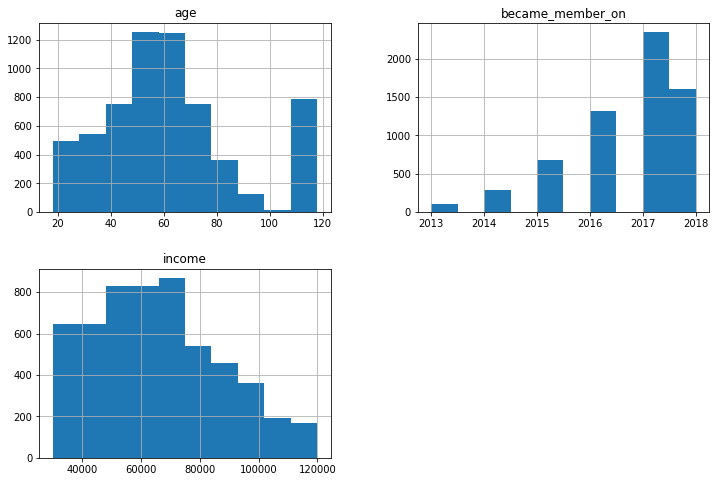

In [118]:
offer_type_df = feature_df[feature_df.offer_name == 'discount_10_10_2']

offer_type_df[['age', 'income', 'became_member_on']].hist(figsize=(12,8));

#### Analysis Commentary:
So it looks like users that are 40 to 60 who are newer (2017 to 2018) in the income range from 50 to 70k

This is very similar to how we saw our data before, let's compare to original data

In [119]:
offer_type_df.shape[0]

6332

### Visualize discount_7_7_3

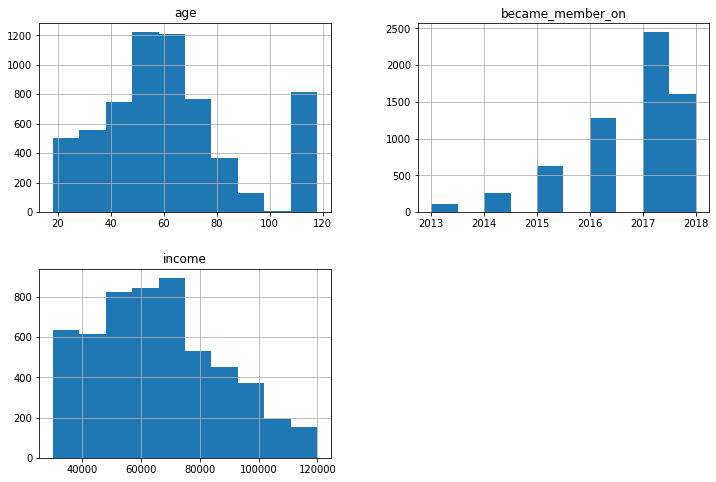

In [120]:
offer_type_df = feature_df[feature_df.offer_name == 'discount_7_7_3']

offer_type_df[['age', 'income', 'became_member_on']].hist(figsize=(12,8));

Similar results, let's look at our two top bogo offers now

### Visualize BOGO Offers (5_5_5 and 5_7_5)

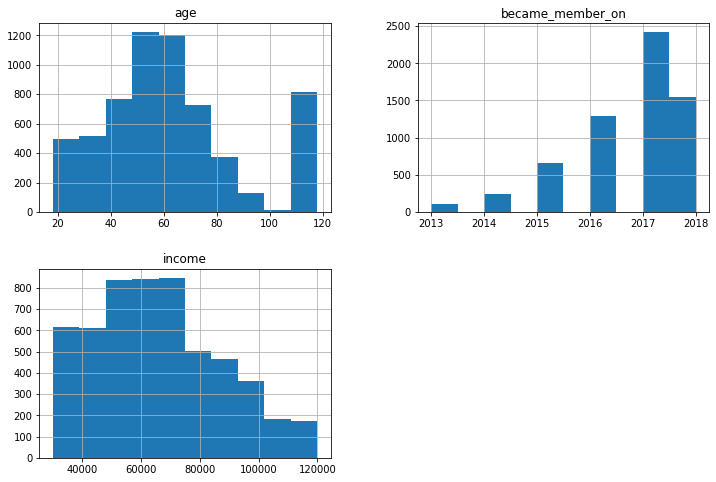

In [29]:
# 5_5_5 bogo offer
offer_type_df = feature_df[feature_df.offer_name == 'bogo_5_5_5']

offer_type_df[['age', 'income', 'became_member_on']].hist(figsize=(12,8));

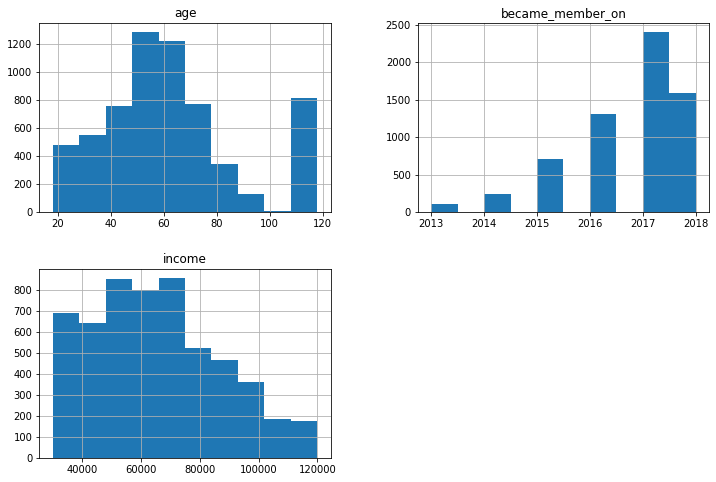

In [30]:
# 5_7_5 bogo offer
offer_type_df = feature_df[feature_df.offer_name == 'bogo_5_7_5']

offer_type_df[['age', 'income', 'became_member_on']].hist(figsize=(12,8));

Very similar all around
## Final Feature engineering
So now we'll complete our final transformations of features:
- drop columns not needed,
- convert income values to 10k buckets
- one-hot encode categorical values (gender, income10K, became_member_on)
- drop income column as it is no longer needed
- scale numeric values (time, difficulty, duration, age, reward)

In [31]:
feature_df.head()

,person,offer_id,time,completed,received,viewed,difficulty,duration,offer_name,reward,...,web,valid,bogo,informational,discount,age,became_member_on,gender,person_id,income
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.0,1,1,1,5.0,7.0,bogo_5_7_5,5.0,...,1.0,1.0,1.0,0.0,0.0,75,2017,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,9.0,0,1,1,0.0,3.0,informational_0_3_0,0.0,...,0.0,1.0,0.0,1.0,0.0,75,2017,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,22.0,1,1,1,10.0,7.0,bogo_10_7_10,10.0,...,0.0,1.0,1.0,0.0,0.0,75,2017,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,25.0,1,1,1,5.0,5.0,bogo_5_5_5,5.0,...,1.0,1.0,1.0,0.0,0.0,75,2017,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,26.0,0,1,1,20.0,10.0,discount_20_10_5,5.0,...,1.0,1.0,0.0,0.0,1.0,118,2017,NaN,a03223e636434f42ac4c3df47e8bac43,NaN


In [32]:
# Split the data into features and target label
drop_columns = ['person', 'person_id', 'offer_id', 'completed', 'offer_name']

offer_raw = feature_df['completed']
features_raw = feature_df.drop(drop_columns, axis = 1)

In [33]:
# convert income values to 10k buckets
features_raw['income10K'] = np.round(features_raw['income'].div(10000))

In [34]:
# view values
features_raw.income10K.value_counts()

6.0     10300
7.0      8668
4.0      7852
5.0      7739
8.0      6419
9.0      4295
10.0     3641
3.0      3546
11.0     1797
12.0      965
Name: income10K, dtype: int64

In [35]:
#one hot encode the gender, became_member_on, income10K columns, drop income column
categorical_columns = ['became_member_on', 'gender', 'income10K']

features_raw = pd.get_dummies(features_raw, columns = categorical_columns)
# drop income column
features_raw.drop(['income'], axis=1, inplace=True)
# confirm one-hot encoding
features_raw.head()

,time,received,viewed,difficulty,duration,reward,email,mobile,social,web,...,income10K_3.0,income10K_4.0,income10K_5.0,income10K_6.0,income10K_7.0,income10K_8.0,income10K_9.0,income10K_10.0,income10K_11.0,income10K_12.0
0,6.0,1,1,5.0,7.0,5.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
1,9.0,1,1,0.0,3.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,22.0,1,1,10.0,7.0,10.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,25.0,1,1,5.0,5.0,5.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,26.0,1,1,20.0,10.0,5.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Normalize numeric features
scaler = MinMaxScaler()

numerical = ['age', 'time', 'difficulty', 'duration', 'reward']
features_raw[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of a record with scaling applied
features_raw.head()

,time,received,viewed,difficulty,duration,reward,email,mobile,social,web,...,income10K_3.0,income10K_4.0,income10K_5.0,income10K_6.0,income10K_7.0,income10K_8.0,income10K_9.0,income10K_10.0,income10K_11.0,income10K_12.0
0,0.200000,1,1,0.25,0.571429,0.5,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
1,0.300000,1,1,0.00,0.000000,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,0.733333,1,1,0.50,0.571429,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,0.833333,1,1,0.25,0.285714,0.5,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,0.866667,1,1,1.00,1.000000,0.5,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# check for nulls one more time
features_raw.isnull().sum()

time                     0
received                 0
viewed                   0
difficulty               0
duration                 0
reward                   0
email                    0
mobile                   0
social                   0
web                      0
valid                    0
bogo                     0
informational            0
discount                 0
age                      0
became_member_on_2013    0
became_member_on_2014    0
became_member_on_2015    0
became_member_on_2016    0
became_member_on_2017    0
became_member_on_2018    0
gender_1                 0
gender_2                 0
gender_3                 0
income10K_3.0            0
income10K_4.0            0
income10K_5.0            0
income10K_6.0            0
income10K_7.0            0
income10K_8.0            0
income10K_9.0            0
income10K_10.0           0
income10K_11.0           0
income10K_12.0           0
dtype: int64

In [38]:
# view numerical data about columns
features_raw.describe()

,time,received,viewed,difficulty,duration,reward,email,mobile,social,web,...,income10K_3.0,income10K_4.0,income10K_5.0,income10K_6.0,income10K_7.0,income10K_8.0,income10K_9.0,income10K_10.0,income10K_11.0,income10K_12.0
count,63288.000000,63288.0,63288.000000,63288.000000,63288.000000,63288.000000,63288.0,63288.000000,63288.000000,63288.000000,...,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000
mean,0.563633,1.0,0.776372,0.385579,0.500688,0.420623,1.0,0.899286,0.599529,0.799425,...,0.056030,0.124068,0.122282,0.162748,0.136961,0.101425,0.067864,0.057531,0.028394,0.015248
std,0.269575,0.0,0.416679,0.277074,0.314795,0.340291,0.0,0.300952,0.489998,0.400434,...,0.229981,0.329661,0.327614,0.369139,0.343809,0.301893,0.251515,0.232856,0.166097,0.122538
min,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.366667,1.0,1.000000,0.250000,0.285714,0.200000,1.0,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.600000,1.0,1.000000,0.500000,0.571429,0.500000,1.0,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.800000,1.0,1.000000,0.500000,0.571429,0.500000,1.0,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modeling
We'll need to split our data to training and testing sets, we'll settle on a 80/20 format for that

In [39]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_raw, 
                                                    offer_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 50630 samples.
Testing set has 12658 samples.


### Naive prediction
Assuming all customer offers are successful in a naive predictor we get the information below.

#### Metrics
We're going to use accuracy and fscore for our measures. Accuracy, of course is good since it high accuracy means it is easy to pinpoint predictions that will be successful. But more importantly we are also using fscore since we are concerned with recall and precision. F1 is a weighted average of the precision and recall so if one or the other gets out of balance this helps keep our predictions on track. I will compare those scores, after we have some naive predictions with three more classifiers to get a good solid base to work from.

In [40]:
'''
TP = np.sum(offer_raw) # Counting the ones as this is the naive case.
FP = offer_raw.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall

TP = np.int(np.sum(offer_raw))
FP = np.int(offer_raw.shape[0]) - TP
TN = 0
FN = 0 

beta = 0.5

accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + beta**2) * ( ( precision * recall ) / ( ( beta**2 * precision ) + recall  ) )

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.4582, F-score: 0.5138]


Now we'll create few functions to both train/predict an evaluate some possible candidate models.

In [46]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    Args:
        (dict) learner - the learning algorithm to be trained and predicted on
        (int) sample_size - the size of samples (number) to be drawn from training set
        (dataframe) X_train - features training set
        (dataframe) y_train - completed training set
        (dataframe) X_test - features testing set
        (dataframe) y_test - completed testing set
    Returns:
        (dataframe) results - a dataframe with results
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("{} Train Set: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(learner.__class__.__name__, results['acc_train'], results['f_train']))
    print("{} Test Set: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(learner.__class__.__name__, results['acc_test'], results['f_test']))    
    # Return the results
    return results

In [42]:
def evaluate(results, accuracy, f1):
    '''
    Visualization code to display results of various learners.

    Args:
      (list) learners - a list of supervised learners
      (int) accuracy - The score for the naive predictor
      (int) fi - The score for the naive predictor
    Return:
      None
    '''

    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,8))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']

    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):

                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")

    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")

    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')

    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, x = 0.63, y = 1.05)
    # Tune the subplot layout
    # Refer - https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html for more details on the arguments
    plt.subplots_adjust(left = 0.125, right = 1.2, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.3)
    plt.tight_layout()
    plt.show()


### Models to Try
We're going to compare three classifying models, SVC, KNeighbors and a Bagging Classifier. We'll train on three different amounts of the data (1%, 10% and all) we'll compare accuracy and f-scores to see which models seem the best for us.

SVC trained on 506 samples.
SVC Train Set: [Accuracy score: 0.8133, F-score: 0.7509]
SVC Test Set: [Accuracy score: 0.7719, F-score: 0.7569]
SVC trained on 5063 samples.
SVC Train Set: [Accuracy score: 0.8233, F-score: 0.7508]
SVC Test Set: [Accuracy score: 0.7960, F-score: 0.7657]
SVC trained on 50630 samples.
SVC Train Set: [Accuracy score: 0.8100, F-score: 0.7289]
SVC Test Set: [Accuracy score: 0.8008, F-score: 0.7675]
KNeighborsClassifier trained on 506 samples.
KNeighborsClassifier Train Set: [Accuracy score: 0.8533, F-score: 0.8070]
KNeighborsClassifier Test Set: [Accuracy score: 0.7246, F-score: 0.7026]
KNeighborsClassifier trained on 5063 samples.
KNeighborsClassifier Train Set: [Accuracy score: 0.8733, F-score: 0.8172]
KNeighborsClassifier Test Set: [Accuracy score: 0.7744, F-score: 0.7483]
KNeighborsClassifier trained on 50630 samples.
KNeighborsClassifier Train Set: [Accuracy score: 0.8500, F-score: 0.7899]
KNeighborsClassifier Test Set: [Accuracy score: 0.7790, F-score: 0.7

C:\Users\drche\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


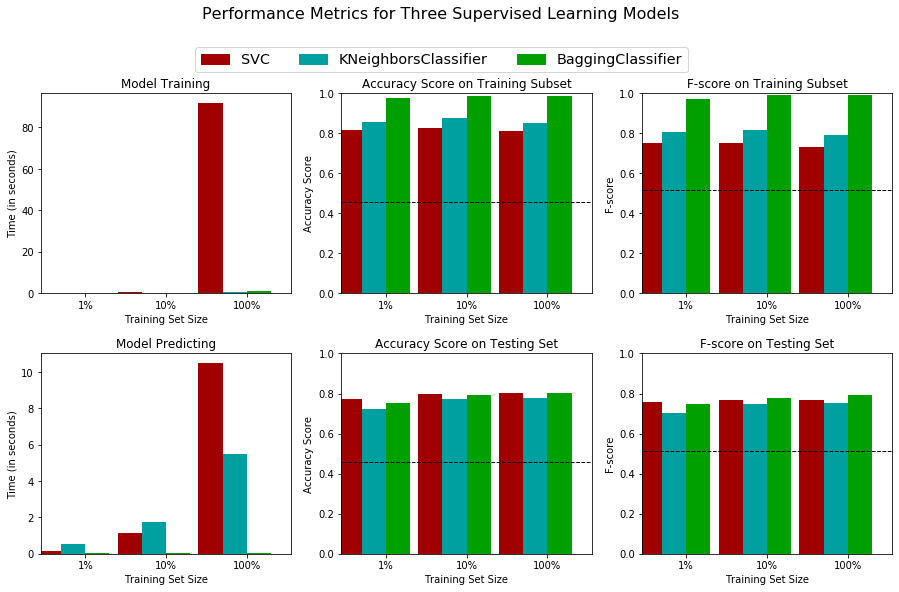

In [47]:
# TODO: Initialize the three models
# clf_A = DecisionTreeClassifier(random_state=0)
# clf_B = AdaBoostClassifier(random_state=0)
# clf_C = RandomForestClassifier(max_depth=2, random_state=0)
clf_A = SVC(random_state=0, gamma = 'auto')
clf_B = KNeighborsClassifier()
clf_C = BaggingClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = np.int(len(y_train) / 10)
samples_1 = np.int(len(y_train) / 100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
# vs.evaluate(results, accuracy, fscore)
evaluate(results, accuracy, fscore)

In [91]:
def feature_plot(importances, X_train, y_train):
    """
    Visualization code to display ten most import features

    Args:
        (list) importances - a list of important features
        (dataframe) X_train - features training set
        (dataframe) y_train - completed training set
    Returns:
        None
    """
    # Display the ten most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (12,8))
    plt.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns, rotation = 90)
    plt.xlim((-0.5, 9.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)

    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()

### Analysis Commentary:
So it looks like the Bagging Classifier is the most reasonable. It is the fastest, generates a good accuracy (<90% on training and <80% on testing sets) and has solid f1 score.

## Important features
So our final question was which features are most important based on our model above. And it looks like the top five were age, time, reward, difficulty and duration (with membership in 2018, membership in 2016, other gender and income of about 60K rounding out the next set).

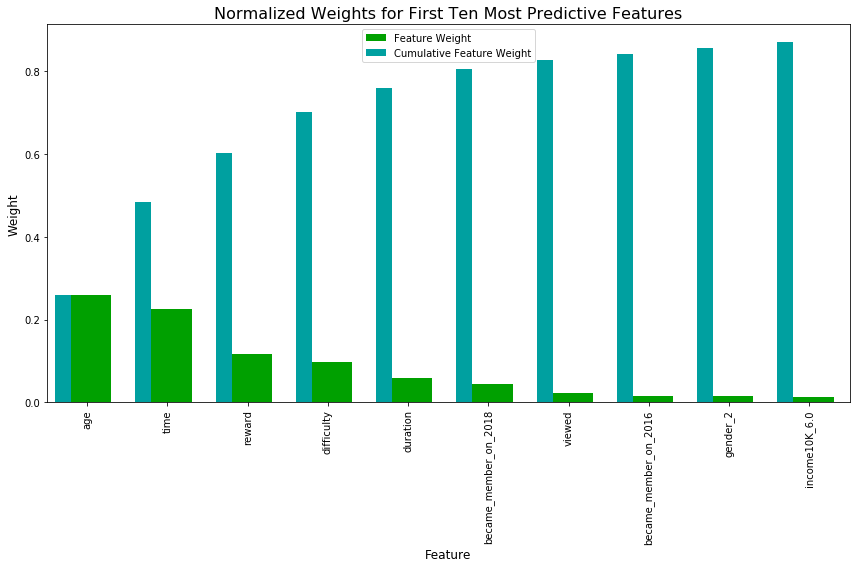

In [92]:
# Train the supervised model on the training set using .fit(X_train, y_train)
# model = AdaBoostClassifier(random_state=0).fit(X_train, y_train)
# model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
# model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
model = BaggingClassifier(random_state=0).fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
# importances = model.feature_importances_
importances = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Plot
# vs.feature_plot(importances, X_train, y_train)
feature_plot(importances, X_train, y_train)

## Conclusions
I started out with two main questions "What types of offers are most successful and will drive more business and what features will drive successful offers?" To get a better understanding of that we reviewed the data, manipulated and visualized it in a few different ways. We combined it and formatted it then created a solid feature set. We were able to view that data and determine a few different offers that tended to be successful (discount_10_10_2, discount 7_7_3 and bogo_5_5_5 and bogo 5_7_5). We created some visualizations of the demographics for those offers, but it wasn't very helpful.

We then we modeled a few different classifiers to find the a good solid model that would predict at a high level (around 80% for our Bagging Classifier) then used that model to determine the features that would be most important using feature_importances_ (age, time, reward, difficulty and duration).
